In [26]:
QUANTIZED_UINT8

NameError: name 'QUANTIZED_UINT8' is not defined

In [45]:
import tensorflow as tf


In [25]:
! tflite_convert -h

2024-05-24 08:51:10.610864: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 08:51:10.650217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 08:51:12.191181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 08:51:12.198945: I external/local_xla/x

In [46]:
! tflite_convert \
  --output_file="output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2.tflite" \
  --graph_def_file="output_ssdlite_mobiledet_car/tflite_graph.pb" \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays="normalized_input_image_tensor" \
  --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,320,320,3 \
  --enable_v1_converter \
  --allow_custom_ops

2024-05-24 10:18:00.552859: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 10:18:00.578782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 10:18:01.723935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 10:18:01.732448: I external/local_xla/x

In [ ]:
import tensorflow as tf
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = 'output_ssdlite_mobiledet_car/tflite_graph.pb', 
    input_arrays = ['normalized_input_image_tensor'],
    output_arrays = ['TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'],
    input_shapes = {"normalized_input_image_tensor" : [1, 320, 320, 3]}
)
converter.quantized_input_stats = {
    'normalized_input_image_tensor': (127.5, 127.5),
}

converter.allow_custom_ops=True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_type = tf.int8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.int8


tflite_model = converter.convert()
with tf.io.gfile.GFile('output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2.tflite', 'wb') as f:
  f.write(tflite_model)

# Read tflite model

In [47]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = tf.lite.Interpreter('output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2.tflite', experimental_delegates=[])

In [48]:
interpreter.get_input_details()

[{'name': 'normalized_input_image_tensor',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [49]:
output_details = interpreter.get_output_details()
output_details

[{'name': 'TFLite_Detection_PostProcess',
  'index': 327,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 328,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 329,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': 

In [50]:
interpreter.allocate_tensors()
interpreter.invoke() # warmup

In [51]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

Evaluating: test/image1.jpg


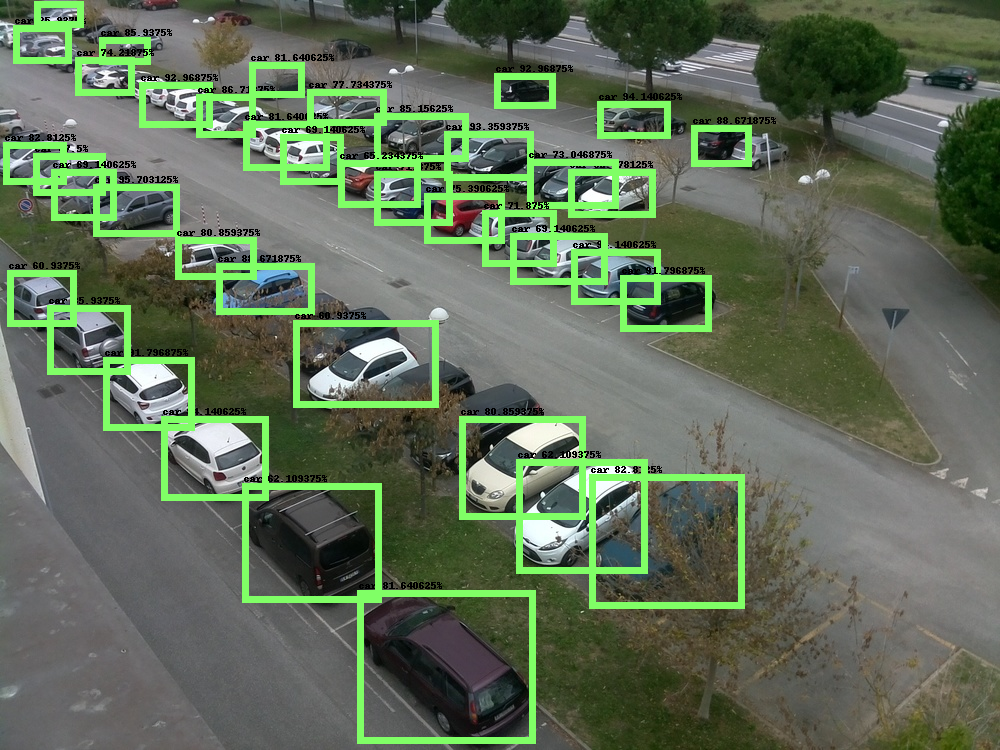

Evaluating: test/image2.jpg


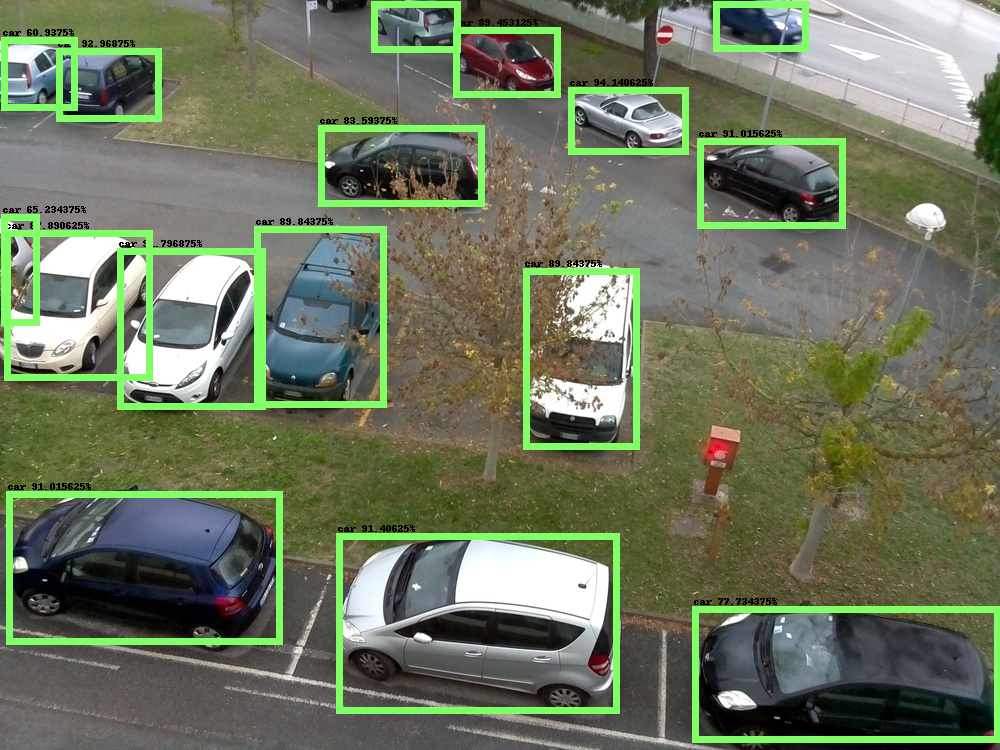

Evaluating: test/image3.jpg


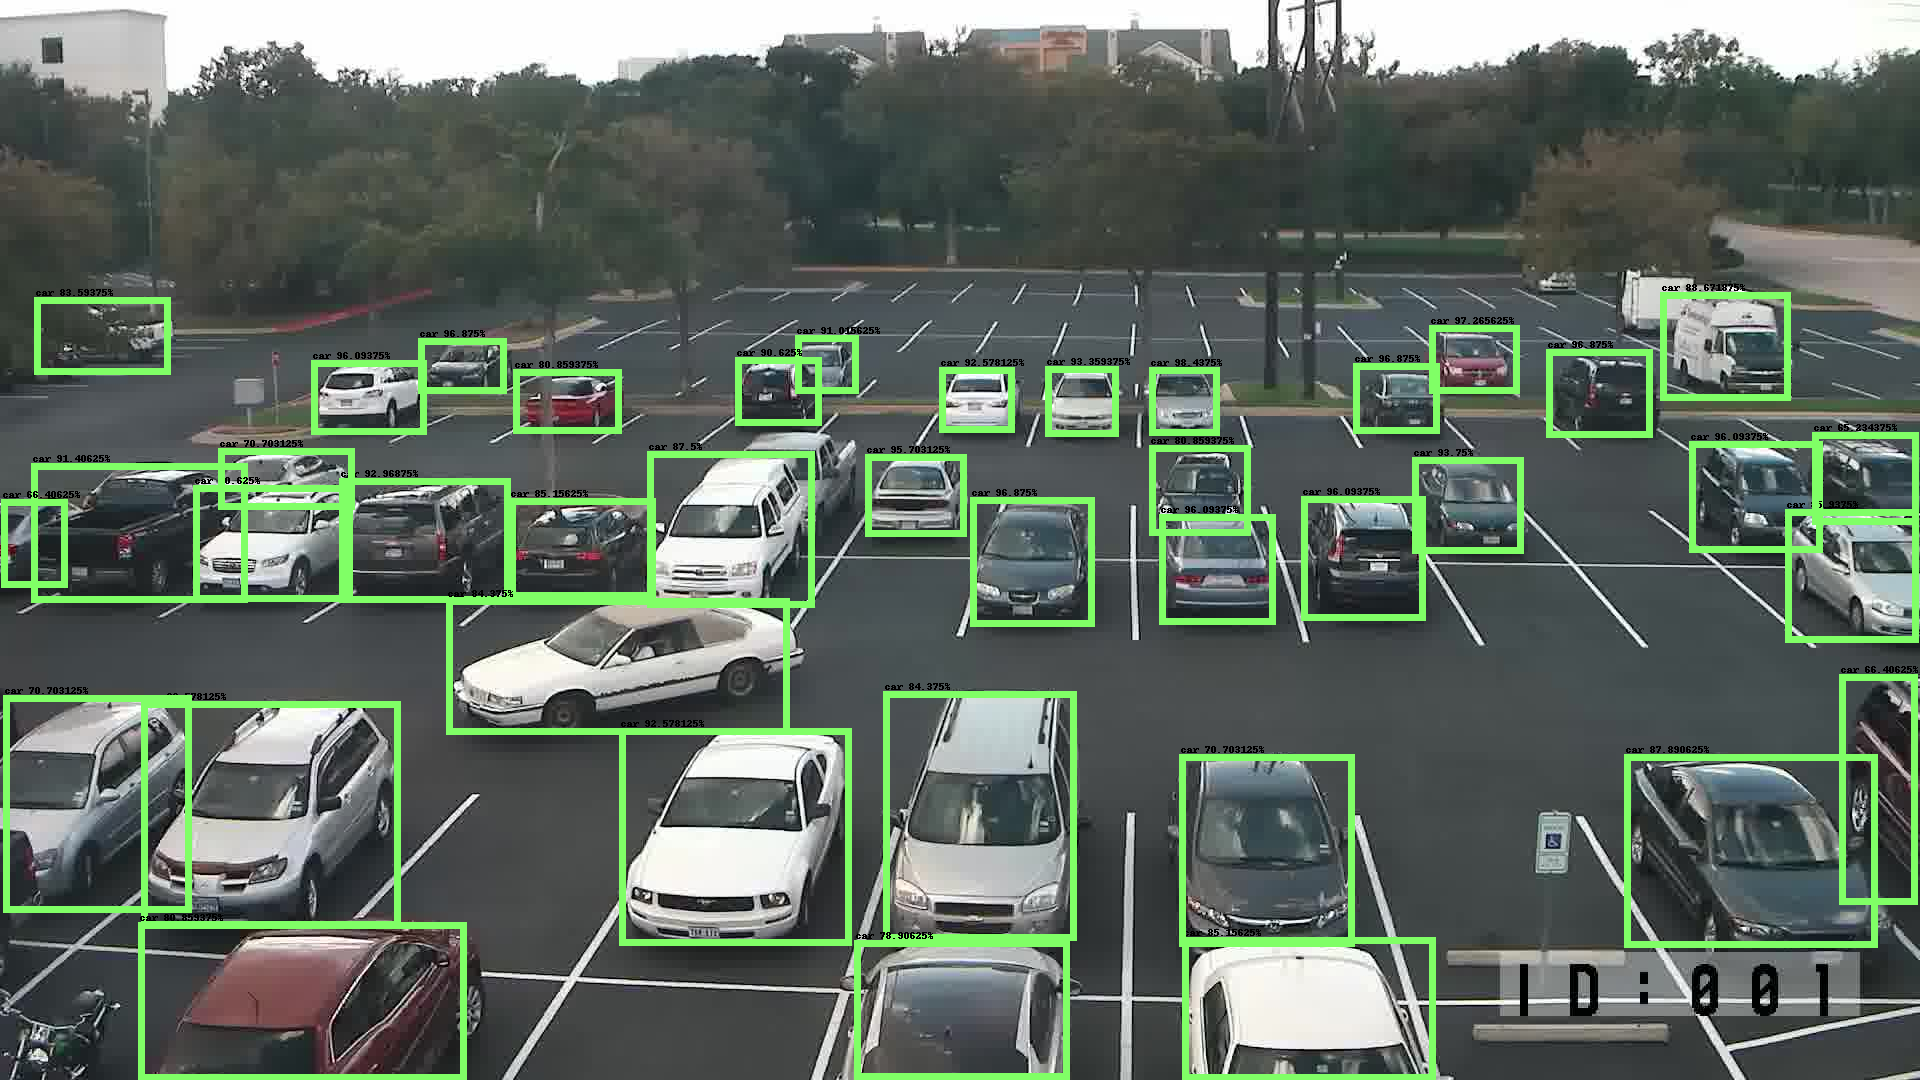

Evaluating: test/image4.jpg


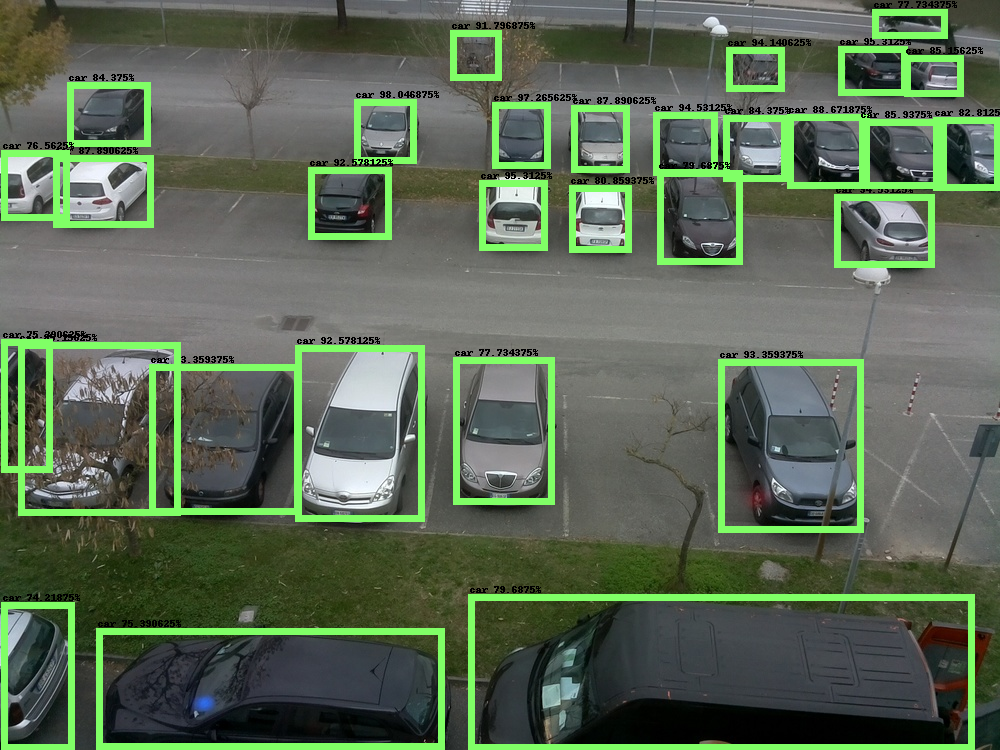

Evaluating: test/image5.jpg


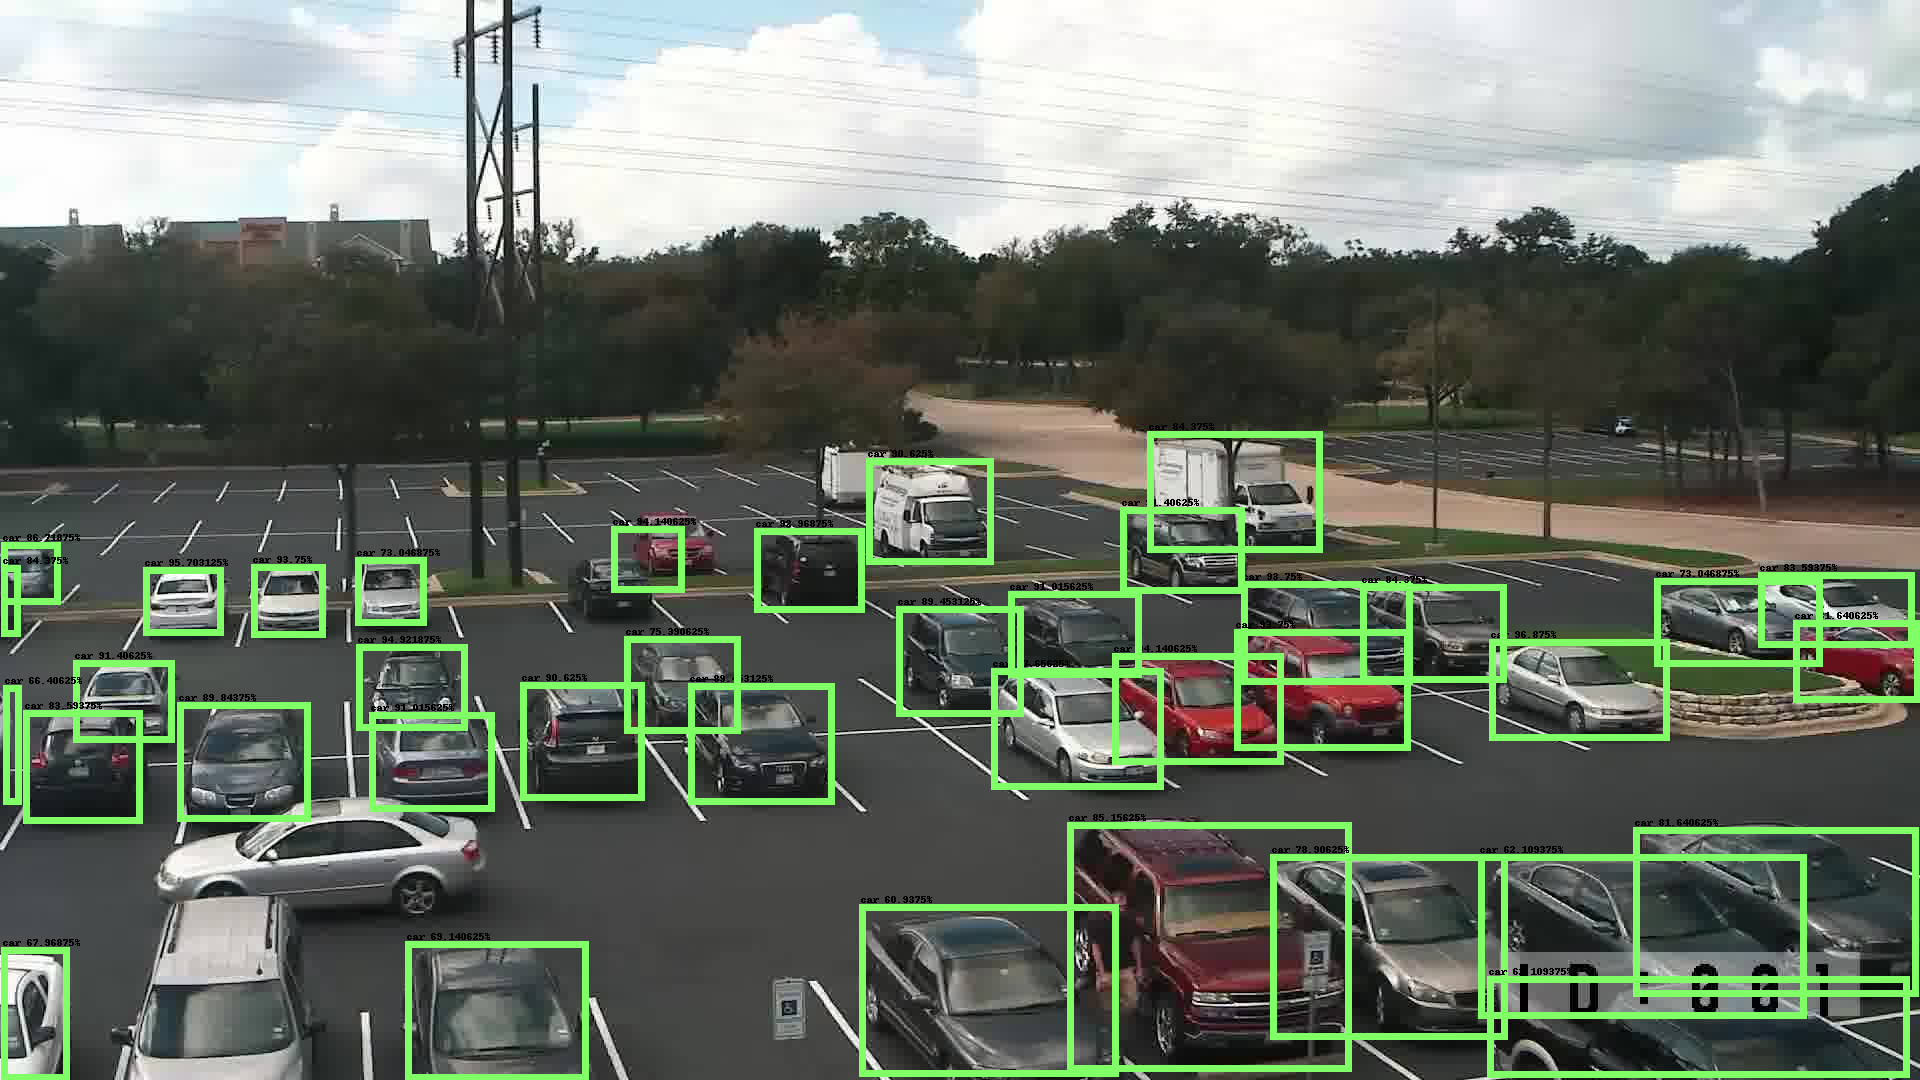

In [52]:
def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  return boxes, classes, scores

test_image_paths = [os.path.join('test', 'image{}.jpg'.format(i)) for i in range(1, 6)]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.asarray(resized_image)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  # print(boxes)
  # break
  # Draw results on image
  colors = {0:(128, 255, 102), 1:(102, 255, 255)}
  labels = read_label_file('car_labels.txt')
  for i in range(len(boxes)):
    if scores[i] > .6:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
      # draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)

In [7]:
# EDGE TPU

In [53]:
! edgetpu_compiler -s output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2.tflite -o output_ssdlite_mobiledet_car

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 612 ms.

Input model: output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2.tflite
Input size: 3.30MiB
Output model: output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2_edgetpu.tflite
Output size: 4.30MiB
On-chip memory used for caching model parameters: 4.11MiB
On-chip memory remaining for caching model parameters: 3.40MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 137
Operation log: output_ssdlite_mobiledet_car/ssdlite_mobiledet_car_v2_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TP